In [36]:
#loading the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,KFold,validation_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from joblib import dump, load
import warnings
import os
from datetime import datetime

# set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

#1. Data Loading and Initial Exploration
# loading the dataset
df = pd.read_csv('insurance.csv')

# Exploring the dataset
print('Dataset loaded successfully!')
print(f'Dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
print('\nDataset Info:')
print(df.info())
print('\nFirst 5 rows:')
print(df.head())
print('\nDataset Description:')
print(df.describe())
print(f'\nMissing Values:')
missing_values = (df.isnull().sum())
print(missing_values)
print(f'Total Missing Values: {missing_values.sum()}')
print(f'Percentage of Missing Values: {missing_values.sum() / len(df) * 100:.2f}%')


Dataset loaded successfully!
Dataset shape: (1338, 7)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.470

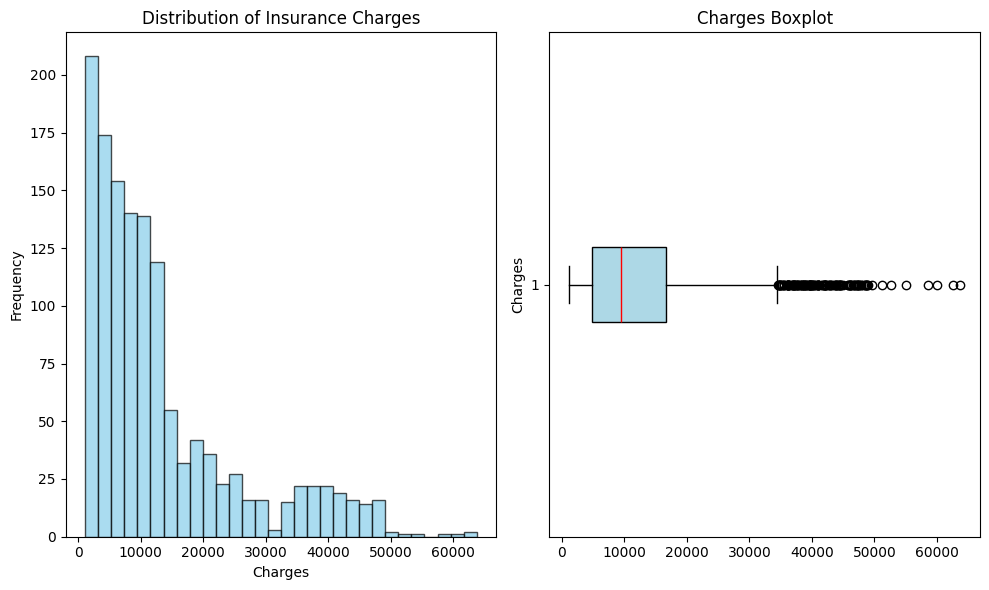

In [2]:
#2 Exploratory Data Analysis and Visualization
#Target variable distribution
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.hist(df['charges'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['charges'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'), medianprops=dict(color='red'))
plt.title('Charges Boxplot')
plt.ylabel('Charges')

plt.tight_layout()
plt.show()

In [3]:
#Charges Statistics

print('\nCharges Statistics:')
print(f'Mean: ${df["charges"].mean():.2f}')
print(f'Median: ${df["charges"].median():.2f}')
print(f'Standard Deviation: ${df["charges"].std():.2f}')
 


Charges Statistics:
Mean: $13270.42
Median: $9382.03
Standard Deviation: $12110.01


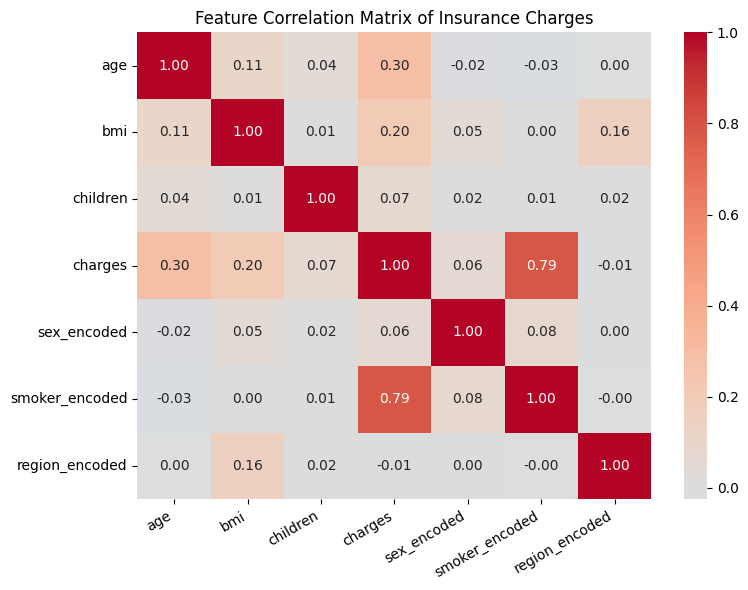

In [4]:
#Correlation Matrix

# Convert categorical variables to numeric using Label Encoding
df_numberic = df.copy() 
le = LabelEncoder()
categorical_cols = ['sex', 'smoker', 'region']

for col in categorical_cols:
    if col in df_numberic.columns:
        df_numberic[f'{col}_encoded'] = le.fit_transform(df_numberic[col])
        df_numberic = df_numberic.drop(col, axis=1)

correlation_matrix = df_numberic.corr()
plt.figure(figsize=(8, 6))  # Increase width and height
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt='.2f',
    annot_kws={"size": 10}  # Smaller annotation font
)
plt.title('Feature Correlation Matrix of Insurance Charges')
plt.xticks(rotation=30, ha ='right')
plt.yticks(rotation=0)  
plt.tight_layout()
plt.show()


In [5]:
#Show correlation with target variable
print('Correlations with Charges(sorted by absolute value):')
charges_correlations = correlation_matrix['charges'].drop('charges').sort_values(key = abs,ascending=False)
print(charges_correlations)

Correlations with Charges(sorted by absolute value):
smoker_encoded    0.787251
age               0.299008
bmi               0.198341
children          0.067998
sex_encoded       0.057292
region_encoded   -0.006208
Name: charges, dtype: float64


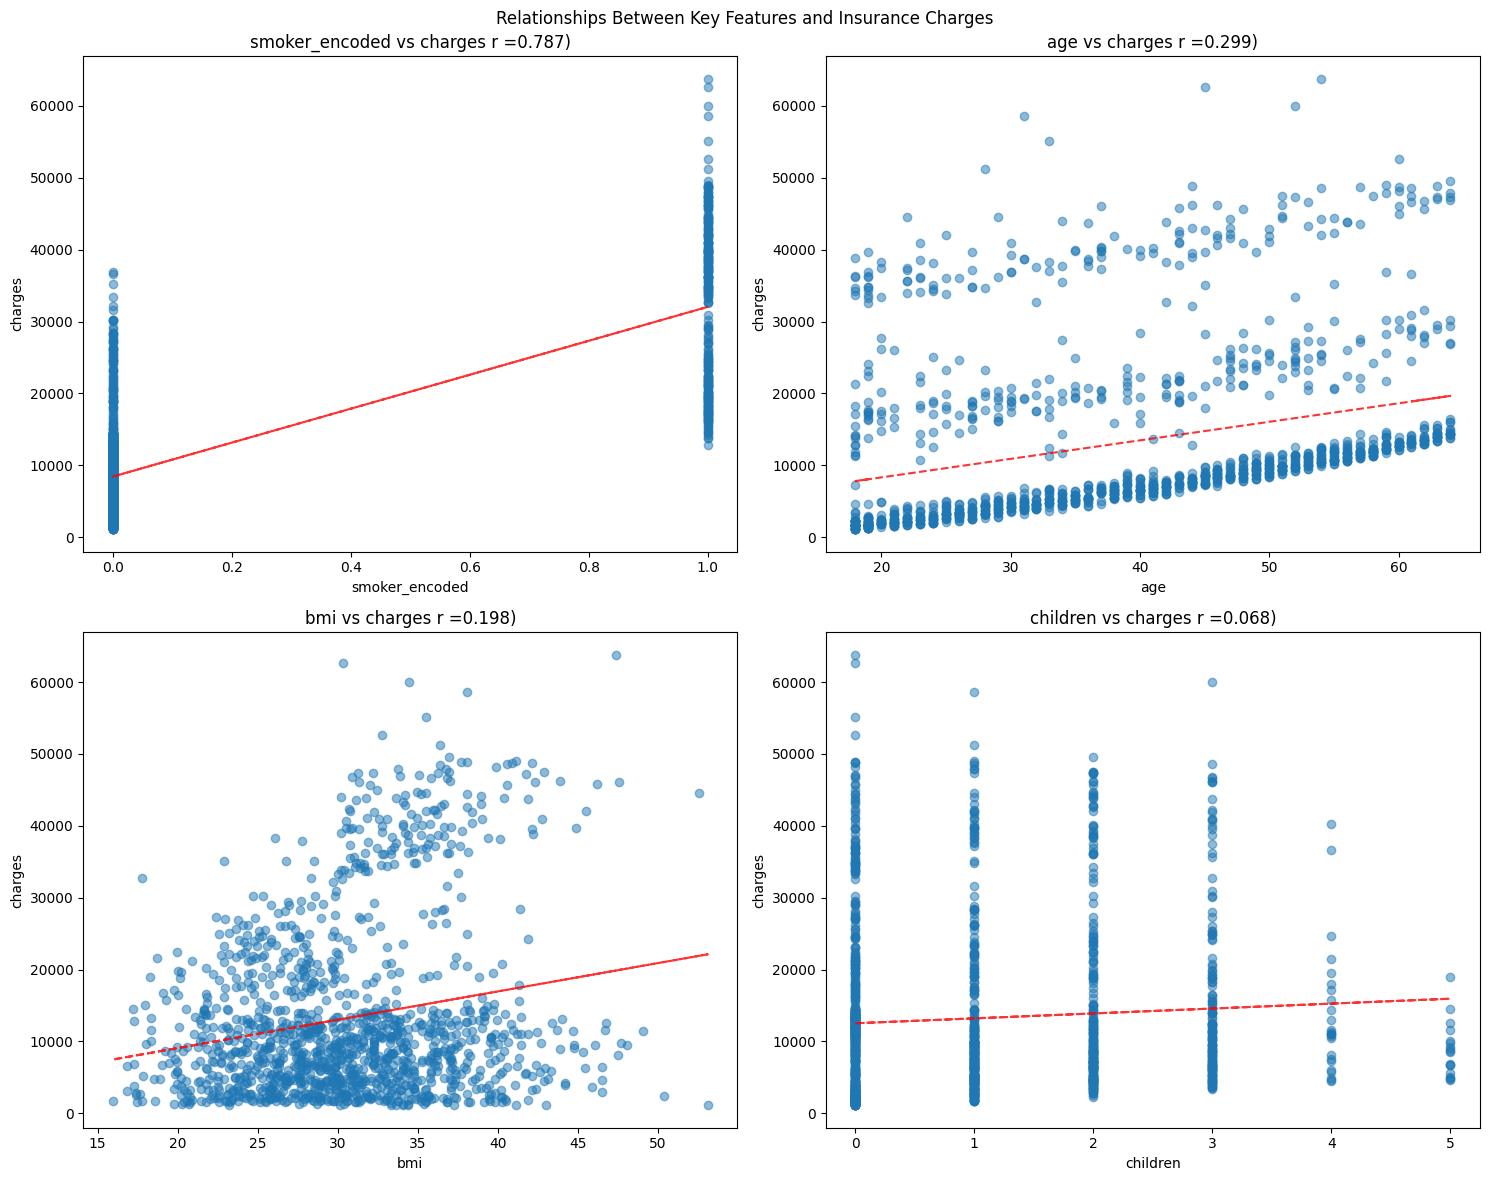

In [6]:
#scatter plot of most correlated features with target variable
fig, axes = plt.subplots(2, 2, figsize = (15, 12))
fig.suptitle('Relationships Between Key Features and Insurance Charges')

# Get top 4 most correlated features (by absolute value)
top_features = charges_correlations.head(4).index

for i, feature in enumerate(top_features):
    row = i // 2
    col = i % 2

    axes[row, col].scatter(df_numberic[feature], df_numberic['charges'], alpha=0.5)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('charges')
    axes[row, col].set_title(f'{feature} vs charges r ={charges_correlations[feature]:.3f})')

    # Add trend line
    z = np.polyfit(df_numberic[feature], df_numberic['charges'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(df_numberic[feature], p(df_numberic[feature]), 'r--', alpha=0.8)

plt.tight_layout()
plt.show()

In [7]:
#3 Data Preprocessing

#3.1 Feature Engineering & Categorical Encoding

#create a copy of the original dataframe for preprocessing
df_processed = df.copy()

#Creating a BMI category feature
df_processed['bmi'] = df['bmi']
df_processed['bmi_category']= pd.cut(df_processed['bmi'],
                                     bins = [0,18.5,25,30, float('inf')],
                                     labels = ['underweight','normal','overweight','obese'])

In [8]:
df_processed

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obese
2,28,male,33.000,3,no,southeast,4449.46200,obese
3,33,male,22.705,0,no,northwest,21984.47061,normal
4,32,male,28.880,0,no,northwest,3866.85520,overweight
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,obese
1334,18,female,31.920,0,no,northeast,2205.98080,obese
1335,18,female,36.850,0,no,southeast,1629.83350,obese
1336,21,female,25.800,0,no,southwest,2007.94500,overweight


In [9]:
#Creating a new feature for age groups
df_processed['age_group'] = pd.cut(df_processed['age'], 
                                    bins = [0, 18, 35, 50, 65, float('inf')],
                                    labels = ['child', 'young_adult', 'middle_aged', 'senior', 'elderly'])

In [10]:
df_processed

,age,sex,bmi,children,smoker,region,charges,bmi_category,age_group
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,young_adult
1,18,male,33.770,1,no,southeast,1725.55230,obese,child
2,28,male,33.000,3,no,southeast,4449.46200,obese,young_adult
3,33,male,22.705,0,no,northwest,21984.47061,normal,young_adult
4,32,male,28.880,0,no,northwest,3866.85520,overweight,young_adult
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,obese,middle_aged
1334,18,female,31.920,0,no,northeast,2205.98080,obese,child
1335,18,female,36.850,0,no,southeast,1629.83350,obese,child
1336,21,female,25.800,0,no,southwest,2007.94500,overweight,young_adult


In [11]:
#new categorical distribution
print('New categorical features created:')
print('\nBMI Category Distribution:')
print(df_processed['bmi_category'].value_counts(normalize=True) * 100)

print('\nAge Group Distribution:')
print(df_processed['age_group'].value_counts(normalize=True) * 100)

New categorical features created:

BMI Category Distribution:
bmi_category
obese          52.690583
overweight     28.849028
normal         16.890882
underweight     1.569507
Name: proportion, dtype: float64

Age Group Distribution:
age_group
young_adult    37.742900
middle_aged    30.493274
senior         26.606876
child           5.156951
elderly         0.000000
Name: proportion, dtype: float64


In [12]:
#One-hot encoding for categorical variables
print('Before one-hot encoding')
print(f'Shape: {df_processed.shape}')
print(f'Columns: {df_processed.columns.tolist()}')

Before one-hot encoding
Shape: (1338, 9)
Columns: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'bmi_category', 'age_group']


In [13]:
#apply one-hot encoding to categorical variables
df_encoded = pd.get_dummies(df_processed, columns = ['sex', 'smoker', 'region', 'bmi_category', 'age_group'], drop_first = True)

In [14]:
df_encoded

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_category_normal,bmi_category_overweight,bmi_category_obese,age_group_young_adult,age_group_middle_aged,age_group_senior,age_group_elderly
0,19,27.900,0,16884.92400,False,True,False,False,True,False,True,False,True,False,False,False
1,18,33.770,1,1725.55230,True,False,False,True,False,False,False,True,False,False,False,False
2,28,33.000,3,4449.46200,True,False,False,True,False,False,False,True,True,False,False,False
3,33,22.705,0,21984.47061,True,False,True,False,False,True,False,False,True,False,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False,False,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False,False,False,True,False,True,False,False
1334,18,31.920,0,2205.98080,False,False,False,False,False,False,False,True,False,False,False,False
1335,18,36.850,0,1629.83350,False,False,False,True,False,False,False,True,False,False,False,False
1336,21,25.800,0,2007.94500,False,False,False,False,True,False,True,False,True,False,False,False


In [15]:
print('\n After one-hot encoding:')
print(f'Shape:{df_encoded.shape}')
print(f'New columns added: {[col for col in df_encoded.columns if col not in df_processed.columns]}')

df_encoded.head()


 After one-hot encoding:
Shape:(1338, 16)
New columns added: ['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest', 'bmi_category_normal', 'bmi_category_overweight', 'bmi_category_obese', 'age_group_young_adult', 'age_group_middle_aged', 'age_group_senior', 'age_group_elderly']


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,bmi_category_normal,bmi_category_overweight,bmi_category_obese,age_group_young_adult,age_group_middle_aged,age_group_senior,age_group_elderly
0,19,27.900,0,16884.92400,False,True,False,False,True,False,True,False,True,False,False,False
1,18,33.770,1,1725.55230,True,False,False,True,False,False,False,True,False,False,False,False
2,28,33.000,3,4449.46200,True,False,False,True,False,False,False,True,True,False,False,False
3,33,22.705,0,21984.47061,True,False,True,False,False,True,False,False,True,False,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False,False,True,False,True,False,False,False


In [16]:
#3.2 Train-Test Split
# separating features and target variable
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [17]:
#feature shape
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'Feature names:{X.columns}.tolist()')

Features shape: (1338, 15)
Target shape: (1338,)
Feature names:Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest', 'bmi_category_normal',
       'bmi_category_overweight', 'bmi_category_obese',
       'age_group_young_adult', 'age_group_middle_aged', 'age_group_senior',
       'age_group_elderly'],
      dtype='object').tolist()


In [18]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, shuffle=True)

In [19]:
#take a look at the training and testing sets
print(f'\n Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')
print(f'Training target set shape: {y_train.shape}')
print(f'Testing target set shape:{y_test.shape}')


 Training set shape: (1070, 15)
Testing set shape: (268, 15)
Training target set shape: (1070,)
Testing target set shape:(268,)


In [20]:
#3.3 Feature scaling using StandardScaler
print('Before scaling - Training set statistic')
print(X_train.describe())

Before scaling - Training set statistic
               age          bmi     children
count  1070.000000  1070.000000  1070.000000
mean     39.357009    30.560397     1.107477
std      14.073960     6.043386     1.215983
min      18.000000    15.960000     0.000000
25%      27.000000    26.205000     0.000000
50%      39.500000    30.210000     1.000000
75%      51.000000    34.496250     2.000000
max      64.000000    53.130000     5.000000


In [21]:
#Initialize the Scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
#Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [23]:
print('\nAfter scaling - Training set statistic')
print(X_train_scaled.describe())


After scaling - Training set statistic
                age           bmi      children      sex_male    smoker_yes  \
count  1.070000e+03  1.070000e+03  1.070000e+03  1.070000e+03  1.070000e+03   
mean  -1.992176e-16 -4.648410e-17 -2.324205e-17 -6.308557e-17  2.988264e-17   
std    1.000468e+00  1.000468e+00  1.000468e+00  1.000468e+00  1.000468e+00   
min   -1.518194e+00 -2.417060e+00 -9.111921e-01 -1.024602e+00 -5.087470e-01   
25%   -8.784157e-01 -7.210253e-01 -9.111921e-01 -1.024602e+00 -5.087470e-01   
50%    1.016470e-02 -5.800739e-02 -8.842793e-02  9.759891e-01 -5.087470e-01   
75%    8.276587e-01  6.515707e-01  7.343363e-01  9.759891e-01 -5.087470e-01   
max    1.751782e+00  3.736342e+00  3.202629e+00  9.759891e-01  1.965613e+00   

       region_northwest  region_southeast  region_southwest  \
count      1.070000e+03      1.070000e+03      1.070000e+03   
mean      -4.648410e-17     -3.320293e-17      7.304645e-17   
std        1.000468e+00      1.000468e+00      1.000468e+00

In [24]:
#Show the effect of scaling on a few features
print('\nScaling effect comparison:')
scaling_comparison = pd.DataFrame({
    'Original Mean': X_train.mean(),
     'Scaled Mean': X_train_scaled.mean(),
    'Original Std Dev': X_train.std(),
    'Scaled Std Dev': X_train_scaled.std()
})
print(scaling_comparison.head(8))


Scaling effect comparison:
                  Original Mean   Scaled Mean  Original Std Dev  \
age                   39.357009 -1.992176e-16         14.073960   
bmi                   30.560397 -4.648410e-17          6.043386   
children               1.107477 -2.324205e-17          1.215983   
sex_male               0.512150 -6.308557e-17          0.500086   
smoker_yes             0.205607  2.988264e-17          0.404334   
region_northwest       0.239252 -4.648410e-17          0.426827   
region_southeast       0.264486 -3.320293e-17          0.441265   
region_southwest       0.246729  7.304645e-17          0.431309   

                  Scaled Std Dev  
age                     1.000468  
bmi                     1.000468  
children                1.000468  
sex_male                1.000468  
smoker_yes              1.000468  
region_northwest        1.000468  
region_southeast        1.000468  
region_southwest        1.000468  


In [25]:
#4 Model Building and Training

#4.1 Initializing models
models = {
    'Linear Regression': LinearRegression(),    
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'lasso': Lasso(alpha=0.1, random_state=42),
    'ridge': Ridge(alpha=0.1, random_state=42)  
}

print(f'Models to be evaluated:')
for name, model in models.items():
    print(f'- {name}')

Models to be evaluated:
- Linear Regression
- Random Forest
- lasso
- ridge


Evaluating Linear Regression...
Linear Regression - Mean RMSE: 6059.24, Std RMSE: 473.78


Evaluating Random Forest...
Random Forest - Mean RMSE: 4932.29, Std RMSE: 513.12


Evaluating lasso...
lasso - Mean RMSE: 6059.21, Std RMSE: 473.86


Evaluating ridge...
ridge - Mean RMSE: 6059.16, Std RMSE: 473.90


Model names: ['Linear Regression', 'Random Forest', 'lasso', 'ridge']
CV means: [np.float64(6059.244786243842), np.float64(4932.289393759479), np.float64(6059.211393887188), np.float64(6059.156731232183)]
CV stds: [np.float64(473.7752415883705), np.float64(513.1249806258974), np.float64(473.8574405515528), np.float64(473.89561966662046)]


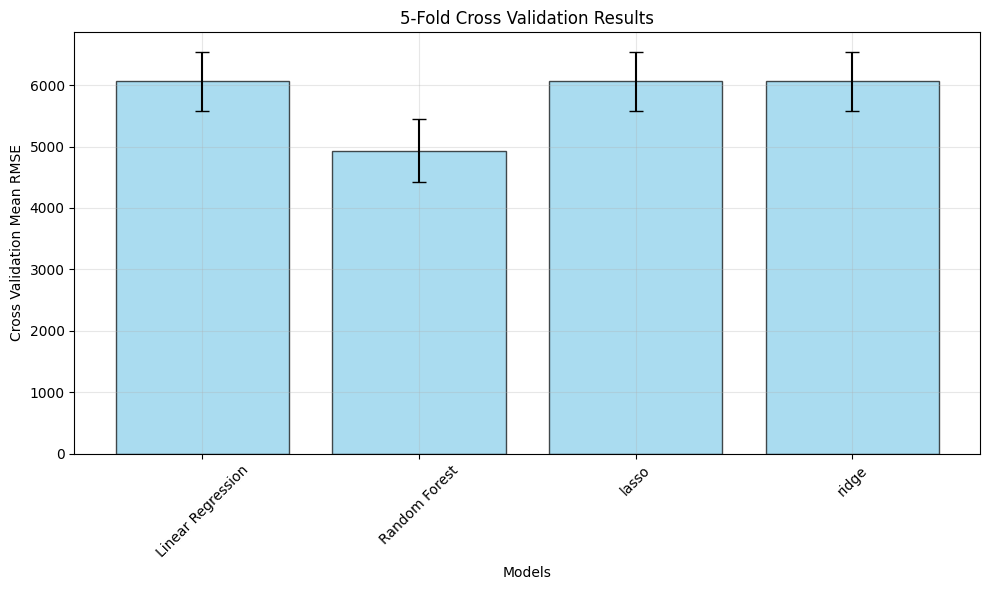

In [26]:
#4.2 Cross Validation
# Initialize KFold cross-validation

cv_scores = {}
cv_folds = 5
kfold = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

# Run cross-validation for each model

for name, model in models.items():
    print(f"Evaluating {name}...")
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='neg_mean_squared_error')
    cv_scores[name] = np.sqrt(-scores) # Convert to RMSE 
    print(f"{name} - Mean RMSE: {cv_scores[name].mean():.2f}, Std RMSE: {cv_scores[name].std():.2f}")
    print('\n')  
    
#Plotting Cross-Validation Results 
model_names = list(cv_scores.keys())
cv_means = [cv_scores[name].mean() for name in model_names]
cv_stds = [cv_scores[name].std() for name in model_names]

print("Model names:", model_names)
print("CV means:", cv_means)
print("CV stds:", cv_stds)

# Create the bar chart
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(model_names))  # Create positions [0, 1, 2, 3]

plt.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color='skyblue', 
        edgecolor='black', alpha=0.7)

plt.xlabel('Models')
plt.ylabel('Cross Validation Mean RMSE')
plt.title('5-Fold Cross Validation Results')
plt.xticks(x_pos, model_names, rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [27]:
#4.3 Model Training and Testing

# dictionaries to store metrics
trained_models = {}
predictions = {}
test_mse = {}
test_rmse = {}
test_mae = {}
test_r2 = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Calculate test scores
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = np.sqrt(mse_value)
    mae_value = mean_absolute_error(y_test, y_pred)  
    r2_value = r2_score(y_test, y_pred)
    
    
    #Store in the dictionaries
    test_mse[name] = mse_value  
    test_rmse[name] = rmse_value
    test_mae[name] = mae_value
    test_r2[name] = r2_value 

    # Print the performance metrics for each model
    print(f'{name} Performance Metrics:')
    print(f' Mean Squared Error (MSE): {mse_value:.4f}')
    print(f' Root Mean Squared Error (RMSE): {rmse_value:.4f}')
    print(f' Mean Absolute Error (MAE): {mae_value:.4f}')
    print(f' R-squared (R²): {r2_value:.4f}')
    print(f' Explained Variance: {r2_value*100:.2f}%')
    print()


Training Linear Regression...
Linear Regression Performance Metrics:
 Mean Squared Error (MSE): 33600694.2318
 Root Mean Squared Error (RMSE): 5796.6106
 Mean Absolute Error (MAE): 4304.1511
 R-squared (R²): 0.7836
 Explained Variance: 78.36%

Training Random Forest...
Random Forest Performance Metrics:
 Mean Squared Error (MSE): 20747589.4225
 Root Mean Squared Error (RMSE): 4554.9522
 Mean Absolute Error (MAE): 2565.2657
 R-squared (R²): 0.8664
 Explained Variance: 86.64%

Training lasso...
lasso Performance Metrics:
 Mean Squared Error (MSE): 33598351.3232
 Root Mean Squared Error (RMSE): 5796.4085
 Mean Absolute Error (MAE): 4303.8379
 R-squared (R²): 0.7836
 Explained Variance: 78.36%

Training ridge...
ridge Performance Metrics:
 Mean Squared Error (MSE): 33596416.9391
 Root Mean Squared Error (RMSE): 5796.2416
 Mean Absolute Error (MAE): 4303.7886
 R-squared (R²): 0.7836
 Explained Variance: 78.36%



In [28]:
#4.4 Performance Metrics Summary

metrics_df = pd.DataFrame({
    'MSE': test_mse,        
    'RMSE': test_rmse,
    'MAE': test_mae,
    'R2': test_r2   
}).T
print("Performance Metrics Summary:")
print(metrics_df.round(4))

Performance Metrics Summary:
      Linear Regression  Random Forest         lasso         ridge
MSE        3.360069e+07   2.074759e+07  3.359835e+07  3.359642e+07
RMSE       5.796611e+03   4.554952e+03  5.796408e+03  5.796242e+03
MAE        4.304151e+03   2.565266e+03  4.303838e+03  4.303789e+03
R2         7.836000e-01   8.664000e-01  7.836000e-01  7.836000e-01


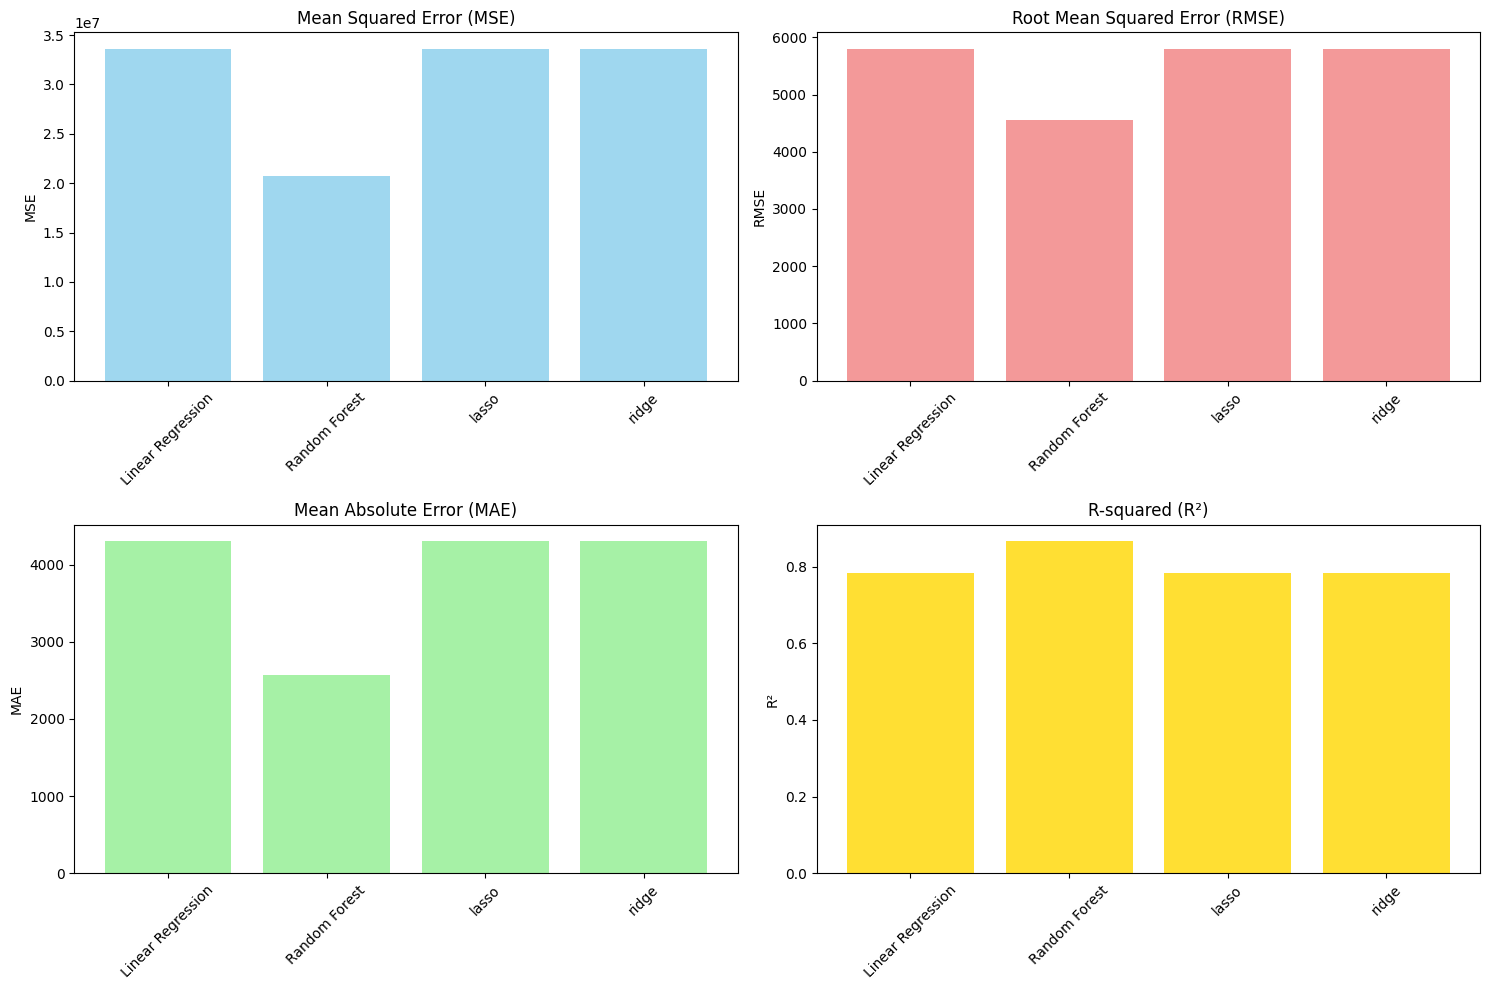

In [29]:
#plotting the performance metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

model_names = list(models.keys())

# MSE
axes[0,0].bar(model_names, [test_mse[name] for name in model_names], color='skyblue', alpha=0.8)
axes[0,0].set_title('Mean Squared Error (MSE)')
axes[0,0].set_ylabel('MSE')
axes[0,0].tick_params(axis='x', rotation=45)

# RMSE
axes[0,1].bar(model_names, [test_rmse[name] for name in model_names], color='lightcoral', alpha=0.8)
axes[0,1].set_title('Root Mean Squared Error (RMSE)')
axes[0,1].set_ylabel('RMSE')
axes[0,1].tick_params(axis='x', rotation=45)

# MAE
axes[1,0].bar(model_names, [test_mae[name] for name in model_names], color='lightgreen', alpha=0.8)
axes[1,0].set_title('Mean Absolute Error (MAE)')
axes[1,0].set_ylabel('MAE')
axes[1,0].tick_params(axis='x', rotation=45)

# R²
axes[1,1].bar(model_names, [test_r2[name] for name in model_names], color='gold', alpha=0.8)
axes[1,1].set_title('R-squared (R²)')
axes[1,1].set_ylabel('R²')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



In [30]:
#4.5 Finding the best model

#Selecting the best model by each metric
best_rmse = metrics_df.loc['RMSE'].idxmin()  # Lowest RMSE
best_r2 = metrics_df.loc['R2'].idxmax()      # Highest R²
best_mae = metrics_df.loc['MAE'].idxmin()    # Lowest MAE

print(f"Best model by RMSE (lowest): {best_rmse}")
print(f"Best model by R² (highest): {best_r2}")  
print(f"Best model by MAE (lowest): {best_mae}")

#Check if metrics agree on the best model
if best_rmse == best_r2 == best_mae:
 print(f'\n Full CONSENSUS: The best model by all metrics is: {best_rmse}')
elif best_rmse == best_r2:
    print(f'\n Partial CONSENSUS: The best model by RMSE and R² is: {best_rmse}')
else:
    print(f'\n Metrics disagree - need to choose based on priorities')


Best model by RMSE (lowest): Random Forest
Best model by R² (highest): Random Forest
Best model by MAE (lowest): Random Forest

 Full CONSENSUS: The best model by all metrics is: Random Forest


In [31]:
#All metrics agree- Random Forest is the best model
best_model_name = 'Random Forest'
best_model = trained_models[best_model_name]

print(f'\nThe best model is: {best_model_name}')




The best model is: Random Forest


Feature Importance Analysis...
Random Forest Feature Importance:
                    feature  importance
4                smoker_yes    0.608618
1                       bmi    0.152570
0                       age    0.130489
10       bmi_category_obese    0.059003
2                  children    0.019047
3                  sex_male    0.006046
6          region_southeast    0.005611
5          region_northwest    0.005340
7          region_southwest    0.004067
9   bmi_category_overweight    0.003026
8       bmi_category_normal    0.002707
12    age_group_middle_aged    0.001352
13         age_group_senior    0.001124
11    age_group_young_adult    0.001001
14        age_group_elderly    0.000000


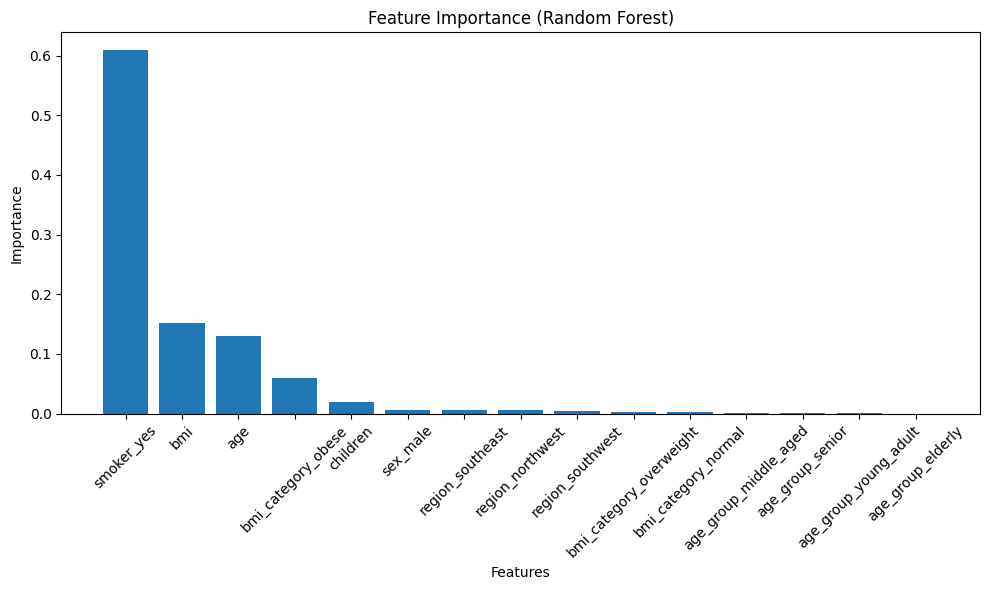

In [32]:
#5. Feature Importance
    
print("Feature Importance Analysis...")

# Get feature importance for Random Forest
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,  # Make sure this matches your feature names
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Random Forest Feature Importance:")
    print(feature_importance)
    
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [33]:
#6.Summary
print("\n" + "="*60)
print("INSURANCE COST PREDICTION - ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset: Insurance Cost Prediction")
print(f"Total samples: {len(df)}")
print(f"Features: {len(X.columns)}")

print(f"\nBest Model: {best_model_name}")
print(f"RMSE: ${test_rmse[best_model_name]:.2f}")
print(f"R²: {test_r2[best_model_name]:.4f} ({test_r2[best_model_name]*100:.1f}% variance explained)")

print("\n" + "="*60)



INSURANCE COST PREDICTION - ANALYSIS SUMMARY

Dataset: Insurance Cost Prediction
Total samples: 1338
Features: 15

Best Model: Random Forest
RMSE: $4554.95
R²: 0.8664 (86.6% variance explained)



In [34]:
#7. Model Saving for deployment

print("="*60)

# Save results for deployment preparation
print(f"\nSaving best model ({best_model_name}) for deployment...")
import joblib

# Save the best model and scaler for regression
joblib.dump(trained_models[best_model_name], 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # Keep this - you need the scaler

print("Model artifacts saved successfully!")
print("Files saved: best_model.pkl, scaler.pkl")

# Optional: Save additional metadata for deployment
model_info = {
    'model_name': best_model_name,
    'features': X.columns.tolist(),
    'performance': {
        'rmse': test_rmse[best_model_name],
        'r2': test_r2[best_model_name],
        'mae': test_mae[best_model_name]
    }
}
joblib.dump(model_info, 'model_info.pkl')
print("Model info saved: model_info.pkl")


Saving best model (Random Forest) for deployment...
Model artifacts saved successfully!
Files saved: best_model.pkl, scaler.pkl
Model info saved: model_info.pkl


📊 Analyzing Feature Importances for: Random Forest


C:\Users\tlhun\AppData\Local\Temp\ipykernel_55976\2503615661.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


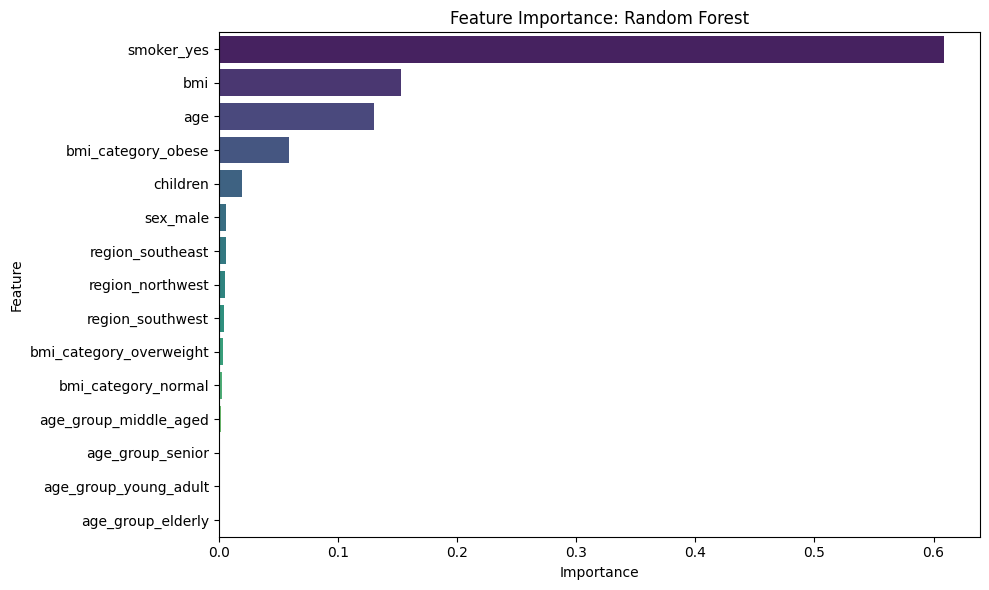

✅ Feature importance plot saved as: models/feature_importance_plot.png
📌 Top 5 Important Features:
  smoker_yes: 0.6086
  bmi: 0.1526
  age: 0.1305
  bmi_category_obese: 0.0590
  children: 0.0190
✅ Model saved as: models/best_model_Random_Forest_20250802_001932.joblib
📦 Artifacts also versioned for future traceability.
📜 Model evaluation summary saved to CSV.
📊 Generating model evaluation plots...


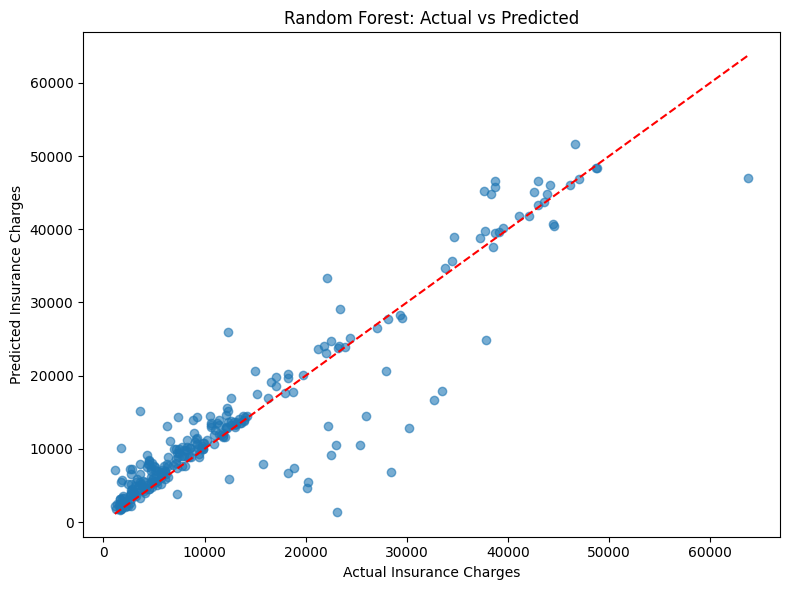

✅ Plot saved to models/predicted_vs_actual.png
📊 Generating residual plots...


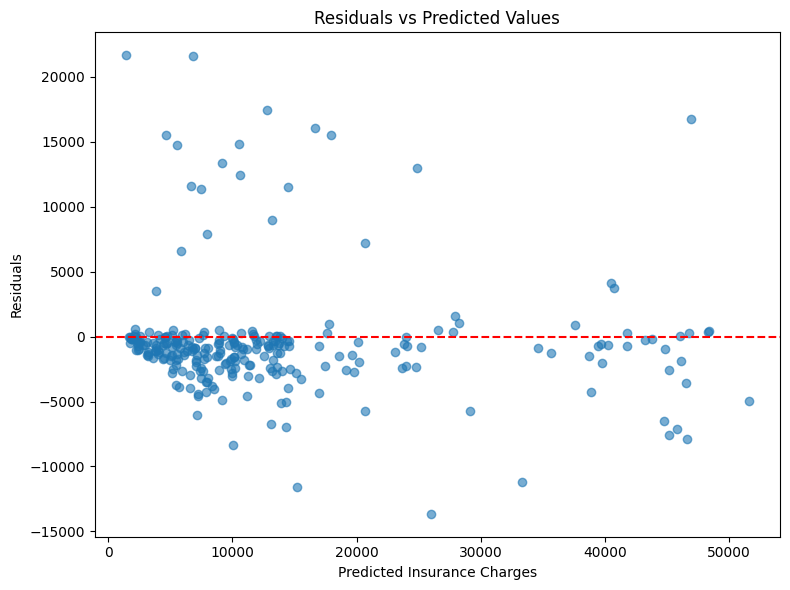

✅ Residuals vs Predicted plot saved.


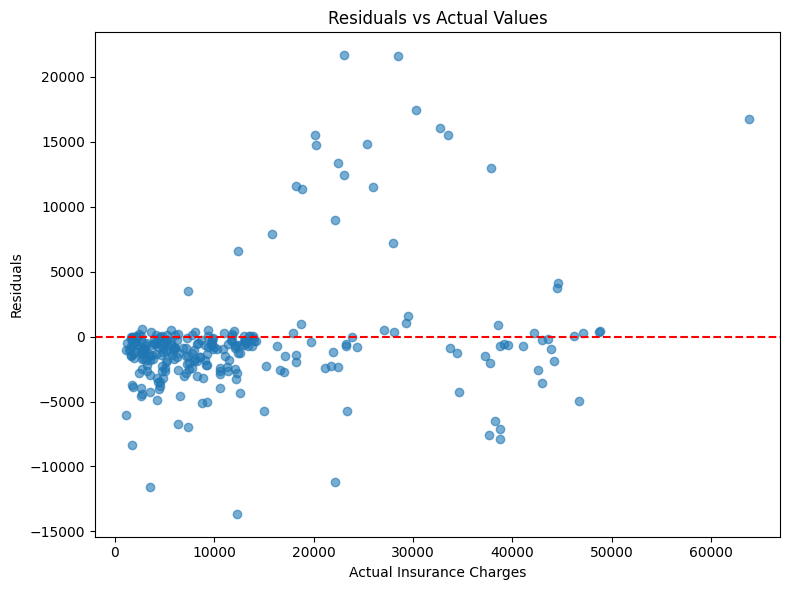

✅ Residuals vs Actual plot saved.


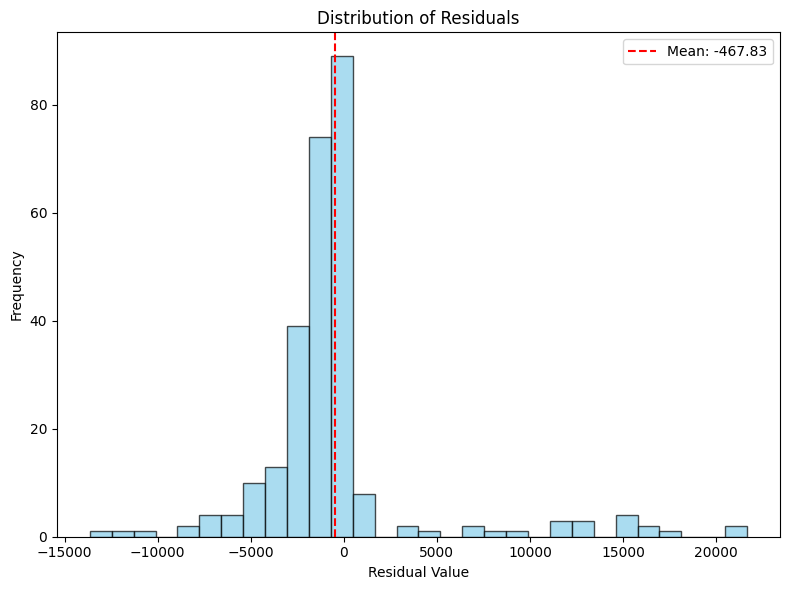

✅ Residuals histogram saved.
----------------------------------------------------------------------------------------------------
✅ FINAL MODEL SELECTION SUMMARY
----------------------------------------------------------------------------------------------------
🏆 Best Model: Random Forest
🔍 R² Score: 0.8664 (86.6% variance explained)
📉 RMSE: $4554.95
📉 MAE: $2565.27
📉 MSE: 20747589.42
📌 Justification: Selected based on lowest RMSE and highest R² on test data.
📅 Model saved with timestamp: 20250802_001932
🌟 Model training and evaluation complete!
🚀 Best model ready for deployment and predictions!


In [37]:
#alternate way of doing this from featue importance

print("=" * 100)
# ============================================================
# 🔍 Feature Importance Analysis
# ============================================================
if best_model_name in ['Random Forest']:  # Fixed model name
    print(f"📊 Analyzing Feature Importances for: {best_model_name}")
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,  # Use your actual feature names
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # 📉 Bar Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importance: {best_model_name}')
    plt.tight_layout()

    # 📅 Save plot
    os.makedirs("models", exist_ok=True)
    plt.savefig("models/feature_importance_plot.png")
    plt.show()
    print("✅ Feature importance plot saved as: models/feature_importance_plot.png")

    # 📁 Show top 5 in console
    top_features = feature_importance_df.head(5)
    print("📌 Top 5 Important Features:")
    for _, row in top_features.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")

print("=" * 100)
# ============================================================
# 📆 Model Versioning and Saving Artifacts
# ============================================================
os.makedirs("models", exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f"models/best_model_{best_model_name.replace(' ', '_')}_{timestamp}.joblib"

# Create metadata
model_metadata = {
    'model_name': best_model_name,
    'r2': test_r2[best_model_name],
    'mae': test_mae[best_model_name],
    'rmse': test_rmse[best_model_name],
    'mse': test_mse[best_model_name],
    'timestamp': timestamp
}

# Save model and metadata
dump(best_model, model_path)
dump(X.columns.tolist(), f"models/feature_names_{timestamp}.joblib")
dump(model_metadata, f"models/model_metadata_{timestamp}.joblib")

# Save current versions (no timestamp)
dump(best_model, "models/best_model.joblib")
dump(X.columns.tolist(), "models/feature_names.joblib")
dump(model_metadata, "models/model_metadata.joblib")

print(f"✅ Model saved as: {model_path}")
print(f"📦 Artifacts also versioned for future traceability.")

print("=" * 100)
# 📊 Save evaluation summary CSV 
metrics_summary = pd.DataFrame({
    'Model': list(test_rmse.keys()),
    'RMSE': list(test_rmse.values()),
    'R2': list(test_r2.values()),
    'MAE': list(test_mae.values()),
    'MSE': list(test_mse.values())
})
metrics_summary.to_csv(f"models/model_evaluation_summary_{timestamp}.csv", index=False)
print("📜 Model evaluation summary saved to CSV.")

print("=" * 100)
# ============================================================
# 📈 Predicted vs Actual Plot
# ============================================================
print("📊 Generating model evaluation plots...")
y_pred_best = predictions[best_model_name]

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Insurance Charges")
plt.ylabel("Predicted Insurance Charges")
plt.title(f"{best_model_name}: Actual vs Predicted")
plt.tight_layout()
plt.savefig("models/predicted_vs_actual.png")
plt.show()
print("✅ Plot saved to models/predicted_vs_actual.png")

print("=" * 100)
# ============================================================
# ✅ Residuals Analysis
# ============================================================
print("📊 Generating residual plots...")
residuals = y_test - y_pred_best

# Residual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Insurance Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.tight_layout()
plt.savefig("models/residuals_vs_predicted.png")
plt.show()
print("✅ Residuals vs Predicted plot saved.")

print("=" * 100)
# Residual vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Insurance Charges")
plt.ylabel("Residuals")
plt.title("Residuals vs Actual Values")
plt.tight_layout()
plt.savefig("models/residuals_vs_actual.png")
plt.show()
print("✅ Residuals vs Actual plot saved.")

print("=" * 100)
# Residual Histogram
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
plt.legend()
plt.tight_layout()
plt.savefig("models/residuals_histogram.png")
plt.show()
print("✅ Residuals histogram saved.")

print("=" * 100)
# ============================================================
# 📢 Final Summary
# ============================================================
print("-" * 100)
print(f"✅ FINAL MODEL SELECTION SUMMARY")
print("-" * 100)
print(f"🏆 Best Model: {best_model_name}")
print(f"🔍 R² Score: {model_metadata['r2']:.4f} ({model_metadata['r2']*100:.1f}% variance explained)")
print(f"📉 RMSE: ${model_metadata['rmse']:.2f}")
print(f"📉 MAE: ${model_metadata['mae']:.2f}")
print(f"📉 MSE: {model_metadata['mse']:.2f}")
print("📌 Justification: Selected based on lowest RMSE and highest R² on test data.")
print(f"📅 Model saved with timestamp: {timestamp}")

print("=" * 100)
print("🌟 Model training and evaluation complete!")
print("🚀 Best model ready for deployment and predictions!")
print("=" * 100)
